# TensorFlow를 활용한 선형회귀 실습

이 노트북에서는 TensorFlow를 사용하여 간단한 선형회귀 문제를 풀어봅니다.

## 주요 단계
1. 데이터 생성 (y = 3x + 2 + 잡음)
2. 모델 정의 (Dense Layer)
3. 손실 함수 및 최적화 방법 설정
4. 학습 진행 및 시각화


In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.20.0


## 1. 데이터 생성

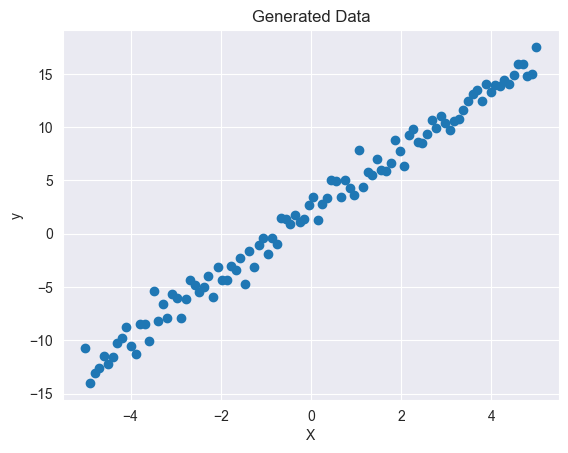

In [31]:
# y = 3x + 2 + noise
n_samples = 100
X = np.linspace(-5, 5, n_samples)
y = 3 * X + 2 + np.random.normal(0, 1, n_samples)

plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Generated Data")
plt.show()

## 2. 모델 정의

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

## 3. 모델 컴파일
- 손실 함수: MSE (Mean Squared Error)
- 최적화 방법: SGD (Stochastic Gradient Descent)

In [33]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='mse')

## 4. 모델 학습

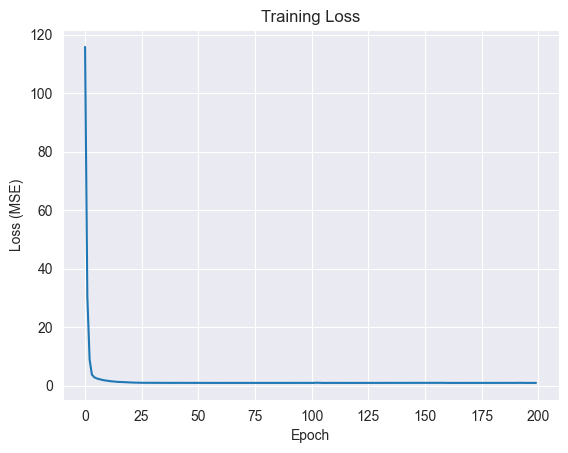

In [34]:
history = model.fit(X, y, epochs=200, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.show()

## 5. 결과 확인

학습된 기울기 W: 2.933, 절편 b: 2.010
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


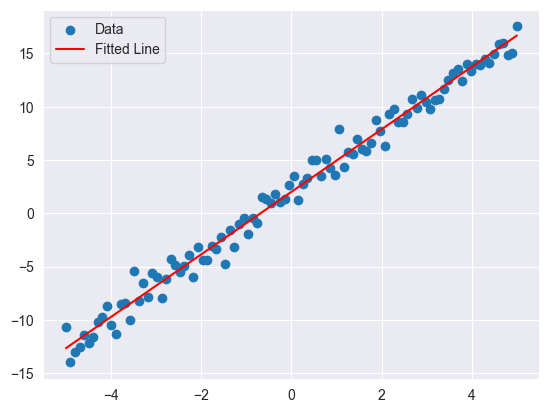

In [35]:
W, b = model.layers[0].get_weights()
print(f"학습된 기울기 W: {W[0][0]:.3f}, 절편 b: {b[0]:.3f}")

y_pred = model.predict(X)

plt.scatter(X, y, label='Data')
plt.plot(X, y_pred, color='red', label='Fitted Line')
plt.legend()
plt.show()

## 생각해보기
- 학습 샘플 수가 작아지면 어떻게 되는가?

선형 회귀에서의 학습(최적화는) MSE(평균제곱오차)값이 최소화 되는 파라미터를 찾는 것인데,
학습 샘플 수가 적을 수록 추정랴의 분산이 커져 테스트 성능이 불안 해 질 수 있다.
또한 샘플수가 줄어 들면 일반화의 오차가 발생 할 수 있다.
보통 샘플 수가 커질 수록 성능이 증가하고 오차가 줄어든다.

- 학습 샘플에 잡음이 많으면 어떻게 되는가? 이 경우 학습 데이터가 많이 필요한가?

학습 샘플의 데이터에 잡음(노이즈)가 많아지면 최적 모델의 기내 성능 상한선이 낮아진다. 잡음이 크면 파라미터 추정의 분산이 커지고 학습이 불안정해진다.
이 경우 학습 데이터가 일반적인 경우 보다 많이 필요한데, 직관적으로 생각한다면 평균을 내면 잡음이 1/n 으로 줄어드는 효과가 있으니 잡음이 없는 데이터를 학습한 모델과 같은 일반화 성능을 내려면 분산의 정도 만큼 데이터가 더 많이 필요하다.


이 수식 E[Test MSE]≈Bias2+Variance+σϵ2​ 에서 σϵ2​ 가 4배면 n도 4배가 필요하다

아래는 샘플 수와 라벨 잡음의 영향을 실험하는 코드이다.

In [2]:
# ==============================
# 실험: 샘플 수 / 라벨 잡음의 영향
# ==============================

import os, random
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")  # GUI 없이 저장
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# 데이터 로드 유틸 (캘리포니아 → 실패시 당뇨병 → 실패시 합성)
def load_regression_data():
    try:
        from sklearn.datasets import fetch_california_housing
        cali = fetch_california_housing()
        X, y = cali.data.astype(np.float64), cali.target.astype(np.float64)
        name = "california_housing"
    except Exception:
        try:
            from sklearn.datasets import load_diabetes
            dia = load_diabetes()
            X, y = dia.data.astype(np.float64), dia.target.astype(np.float64)
            name = "diabetes_builtin"
        except Exception:
            from sklearn.datasets import make_regression
            X, y = make_regression(
                n_samples=5000, n_features=8, n_informative=8,
                noise=15.0, random_state=42
            )
            X, y = X.astype(np.float64), y.astype(np.float64)
            name = "synthetic_make_regression"
    return X, y, name

# 재현성
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

X, y, data_name = load_regression_data()
print(f"[DATA] {data_name}, X.shape={X.shape}, y.shape={y.shape}")

# Train/Test 분리 (한 번 고정)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=SEED)

def make_model(alpha=1e-3):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=alpha, random_state=SEED))
    ])

def eval_once(Xtr, ytr, Xte, yte):
    model = make_model()
    model.fit(Xtr, ytr)
    yhat = model.predict(Xte)
    return r2_score(yte, yhat), mean_squared_error(yte, yhat)

# ----------------------------
# A) 샘플 수 효과 (no added noise)
# ----------------------------
n_total = X_tr.shape[0]
sizes = [100, 200, 500, 1000, 2000, n_total]
sizes = [s for s in sizes if s <= n_total]
repeats = 5

rec_size = []
for s in sizes:
    for rep in range(repeats):
        idx = np.random.choice(n_total, size=s, replace=False)
        r2, mse = eval_once(X_tr[idx], y_tr[idx], X_te, y_te)
        rec_size.append({"n_train": s, "rep": rep, "R2": r2, "MSE": mse})

df_size = pd.DataFrame(rec_size)
df_size_agg = df_size.groupby("n_train").agg(
    R2_mean=("R2","mean"), R2_std=("R2","std"),
    MSE_mean=("MSE","mean"), MSE_std=("MSE","std")
).reset_index()

# Plot: 샘플 수 → R2
plt.figure(figsize=(7,5))
plt.title(f"Effect of Training Sample Size (Data={data_name})")
plt.xlabel("Number of training samples")
plt.ylabel("R2 (higher is better)")
plt.plot(df_size_agg["n_train"], df_size_agg["R2_mean"], marker="o")
plt.fill_between(df_size_agg["n_train"],
                 df_size_agg["R2_mean"]-df_size_agg["R2_std"],
                 df_size_agg["R2_mean"]+df_size_agg["R2_std"], alpha=0.2)
plt.grid(True, linestyle=":")
plt.savefig("size_vs_r2.png", dpi=150, bbox_inches="tight")
plt.close()
print("Saved: size_vs_r2.png")

# ----------------------------
# B) 라벨 잡음 레벨 효과 (full n)
#    y_tr에만 잡음 추가, 평가는 깨끗한 y_te로
# ----------------------------
y_std = np.std(y_tr)
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.5, 1.0]  # y 표준편차의 비율
repeats_noise = 5

rec_noise = []
for nl in noise_levels:
    for rep in range(repeats_noise):
        noise = np.random.normal(0.0, nl * y_std, size=y_tr.shape[0])
        r2, mse = eval_once(X_tr, y_tr + noise, X_te, y_te)
        rec_noise.append({"noise_level": nl, "rep": rep, "R2": r2, "MSE": mse})

df_noise = pd.DataFrame(rec_noise)
df_noise_agg = df_noise.groupby("noise_level").agg(
    R2_mean=("R2","mean"), R2_std=("R2","std"),
    MSE_mean=("MSE","mean"), MSE_std=("MSE","std")
).reset_index()

# Plot: 잡음 → R2
plt.figure(figsize=(7,5))
plt.title(f"Effect of Label Noise (Full n, Data={data_name})")
plt.xlabel("Noise level (as fraction of target std)")
plt.ylabel("R2 (higher is better)")
plt.plot(df_noise_agg["noise_level"], df_noise_agg["R2_mean"], marker="o")
plt.fill_between(df_noise_agg["noise_level"],
                 df_noise_agg["R2_mean"]-df_noise_agg["R2_std"],
                 df_noise_agg["R2_mean"]+df_noise_agg["R2_std"], alpha=0.2)
plt.grid(True, linestyle=":")
plt.savefig("noise_vs_r2.png", dpi=150, bbox_inches="tight")
plt.close()
print("Saved: noise_vs_r2.png")

# ----------------------------
# C) “잡음이 많으면 데이터가 많이 필요한가?” 확인
#    저잡음 vs 고잡음에서 학습곡선 비교
# ----------------------------
sizes_lc = [100, 200, 500, 1000, 2000, n_total]
sizes_lc = [s for s in sizes_lc if s <= n_total]
repeats_lc = 5
low_noise, high_noise = 0.0, 0.5

def learning_curve_with_noise(nl):
    recs = []
    for s in sizes_lc:
        for rep in range(repeats_lc):
            idx = np.random.choice(n_total, size=s, replace=False)
            Xs, ys = X_tr[idx], y_tr[idx]
            ys_noisy = ys + np.random.normal(0.0, nl * y_std, size=ys.shape[0])
            r2, mse = eval_once(Xs, ys_noisy, X_te, y_te)
            recs.append({"n_train": s, "R2": r2, "MSE": mse})
    return pd.DataFrame(recs).groupby("n_train").agg(
        R2_mean=("R2","mean"), R2_std=("R2","std"),
        MSE_mean=("MSE","mean"), MSE_std=("MSE","std")
    ).reset_index()

df_low  = learning_curve_with_noise(low_noise)
df_high = learning_curve_with_noise(high_noise)

# Plot: Low noise 학습곡선
plt.figure(figsize=(7,5))
plt.title(f"Learning Curve (Low Noise={low_noise}, Data={data_name})")
plt.xlabel("Number of training samples")
plt.ylabel("R2 (higher is better)")
plt.plot(df_low["n_train"], df_low["R2_mean"], marker="o")
plt.fill_between(df_low["n_train"],
                 df_low["R2_mean"]-df_low["R2_std"],
                 df_low["R2_mean"]+df_low["R2_std"], alpha=0.2)
plt.grid(True, linestyle=":")
plt.savefig("learning_curve_low_noise.png", dpi=150, bbox_inches="tight")
plt.close()
print("Saved: learning_curve_low_noise.png")

# Plot: High noise 학습곡선
plt.figure(figsize=(7,5))
plt.title(f"Learning Curve (High Noise={high_noise}, Data={data_name})")
plt.xlabel("Number of training samples")
plt.ylabel("R2 (higher is better)")
plt.plot(df_high["n_train"], df_high["R2_mean"], marker="o")
plt.fill_between(df_high["n_train"],
                 df_high["R2_mean"]-df_high["R2_std"],
                 df_high["R2_mean"]+df_high["R2_std"], alpha=0.2)
plt.grid(True, linestyle=":")
plt.savefig("learning_curve_high_noise.png", dpi=150, bbox_inches="tight")
plt.close()
print("Saved: learning_curve_high_noise.png")

# CSV 요약 저장
df_size_agg.to_csv("size_experiment_summary.csv", index=False)
df_noise_agg.to_csv("noise_experiment_summary.csv", index=False)

print("\nFiles saved in current working directory:")
print("- size_vs_r2.png")
print("- noise_vs_r2.png")
print("- learning_curve_low_noise.png")
print("- learning_curve_high_noise.png")
print("- size_experiment_summary.csv")
print("- noise_experiment_summary.csv")


[DATA] california_housing, X.shape=(20640, 8), y.shape=(20640,)
Saved: size_vs_r2.png
Saved: noise_vs_r2.png
Saved: learning_curve_low_noise.png
Saved: learning_curve_high_noise.png

Files saved in current working directory:
- size_vs_r2.png
- noise_vs_r2.png
- learning_curve_low_noise.png
- learning_curve_high_noise.png
- size_experiment_summary.csv
- noise_experiment_summary.csv


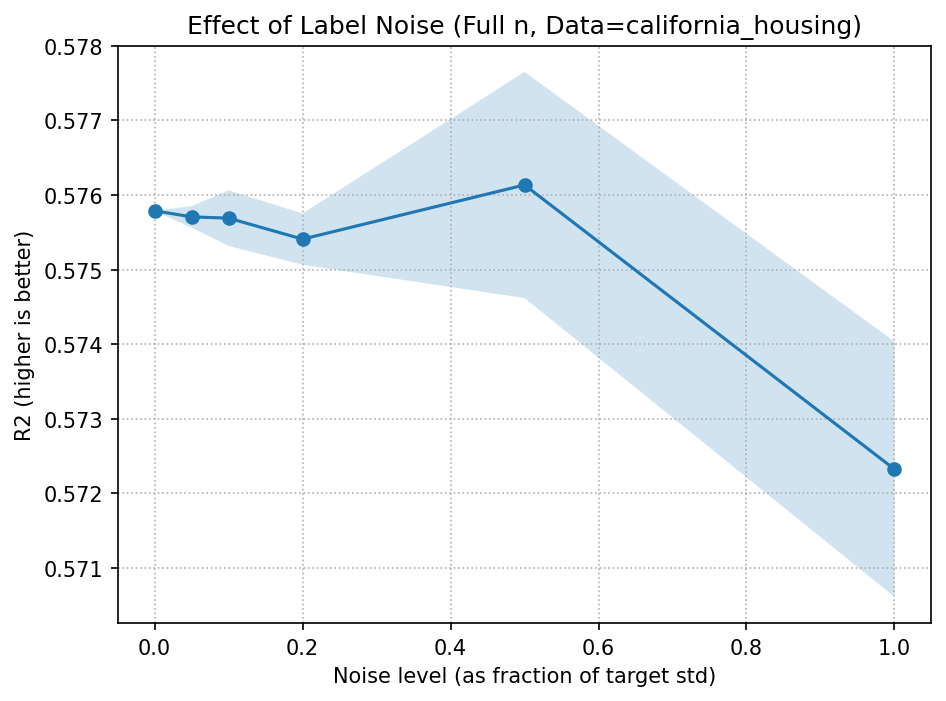
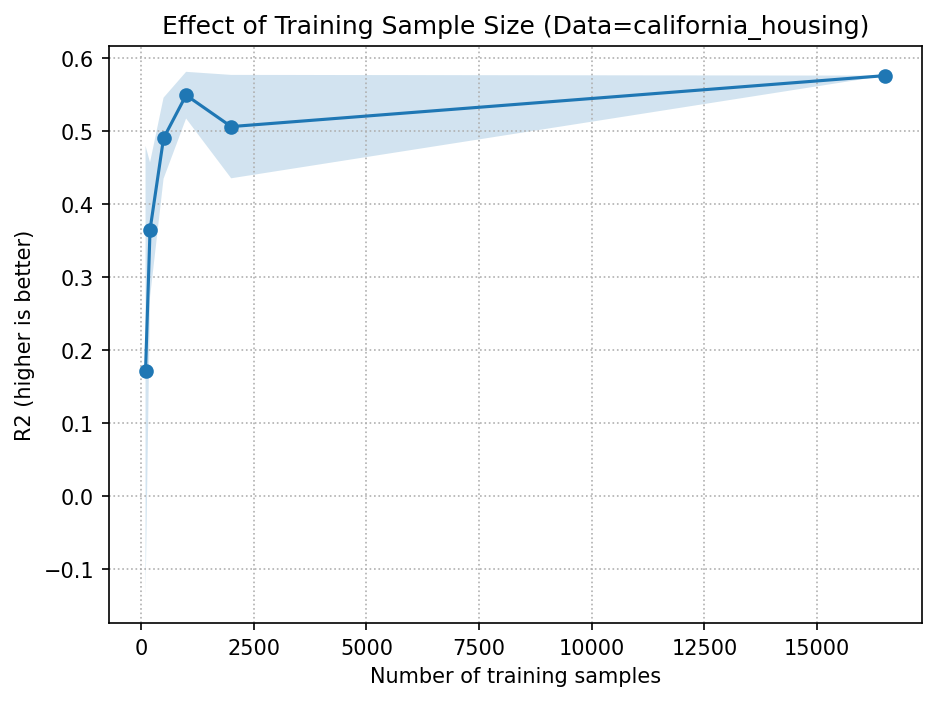

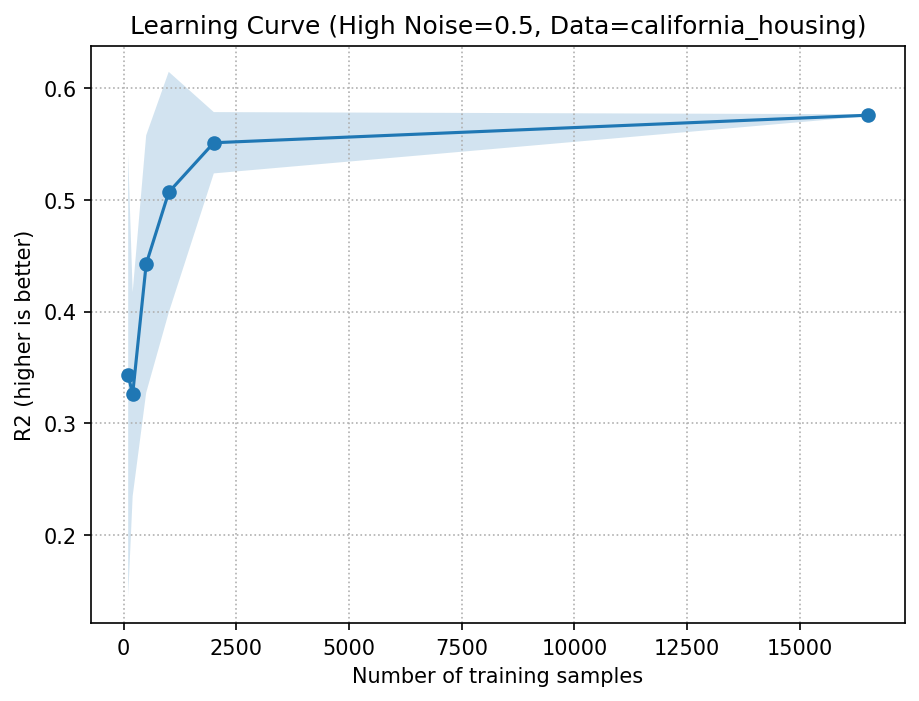
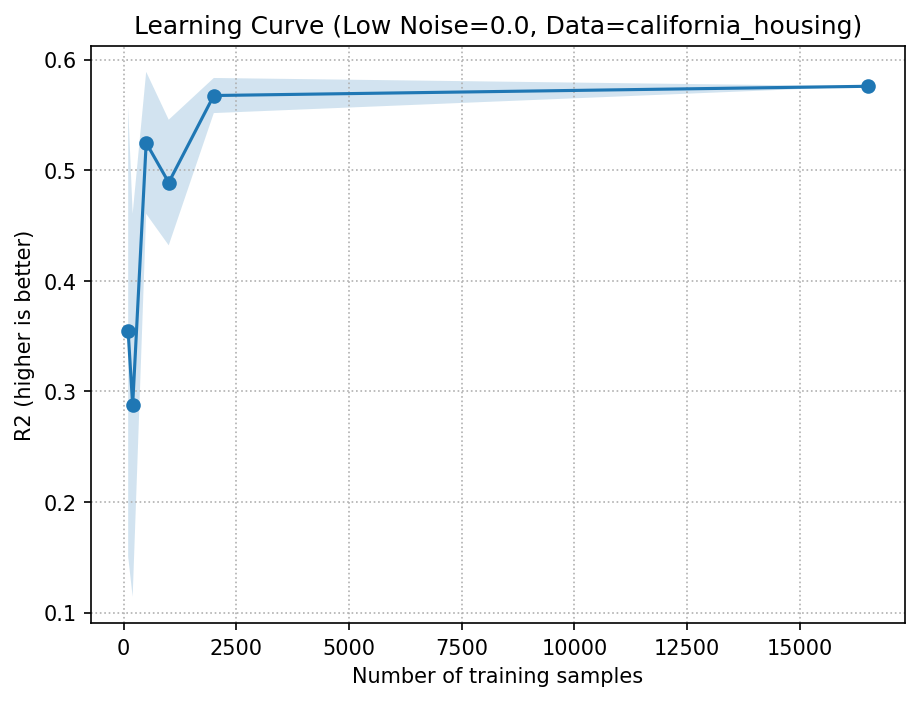
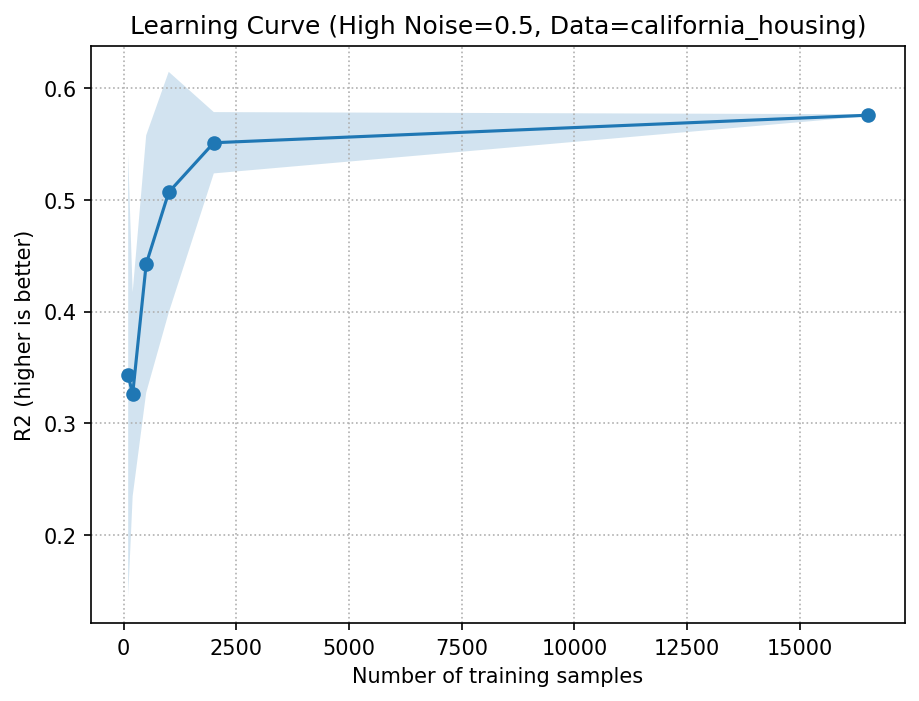